In [4]:
import cv2 as cv
from dataclasses import dataclass
import matplotlib.pyplot as plt
from glob import glob
from scipy.optimize import curve_fit
import numpy as np

# Utils methods

## DFA Analysis
For defenition of crossovers we suggest to use the following functions based on ReLU function.

$$
f(x, R, C) = \frac{log(1 + e^{R (x - C)})}{R(x - C)   \sqrt{1 + (x-C)^2}},
$$
where $R$ is coefficient which is proportonal to sharpness (rigidity) of a DFA crossover, $C$ is position of the crossover. And reversed version as follwing

$$
f_{rev}(x, R, C) = \frac{log(1 + e^{R (x - C)})}{ - R (x - C)   \sqrt{1 + (x-C)^2}},
$$

Based on this functions we defined the folling function $tf$ which can be ased as base element for fluctuation characteristic approximation.

$$
tf(x, R, C_1, C_2) = - f(x, R, C) - f_{rev}(x, R, C)
$$

### Single crossiver case

The single crossover case can be defined as following:

$$
y(x, R_{12}, C_{12}, S_1, S_2) = y_0 + x S_1 * tf(x, R_{12}, -100, C_{12}) + S_2 * tf(x, R_{12}, C_{12}, 100),
$$

where $y_0$ is function value if $x = 0$, $S_i$ is slope of $i$-th section of DFA, $C_{ij}$ is crossover possition between sections $i$ and $j$, $R_{ij}$ is sharpness of crossover between sections $i$ and $j$.

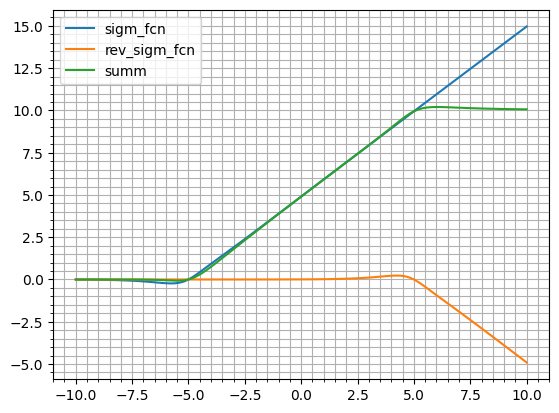

In [5]:
def f_fcn(x, R, C):
    return np.log(1 + np.exp(R *(x - C))) / R * (x-C) / np.sqrt(1 + (x-C)**2)

def rev_f_fcn(x, R, C):
    return np.log(1 + np.exp(R *(x - C))) / R * - (x-C) / np.sqrt(1 + (x-C)**2)

def tf(x, R, C1, C2):
    return - f_fcn(x, R, C2) - rev_f_fcn(x, R, C1)

def single_cross_fcn(x, y_0, C_12, slope_1, slope_2, R_12):
    return y_0 \
        + slope_1 * tf(x, R_12, -100, C_12) \
        + slope_2 * tf(x, R_12, C_12, 100)

t = np.linspace(-10, 10, num=101, endpoint=True)
fig, ax = plt.subplots()
plt.plot(t, f_fcn(t, 1, -5), label="sigm_fcn")
plt.plot(t, rev_f_fcn(t, 1, 5), label="rev_sigm_fcn")
plt.plot(t, tf(t, 2, -5, 5), label="summ")
plt.grid(which='both')
ax.minorticks_on()
plt.legend()
# plt.ylim(-2, 2)
plt.show()

for example, plot a function with the following paarameters: $y_0 = 0$, $C_{12} = 50$, $S_1 = 2$, $S_2 = 1$, $R_{12} = 0.1$ and $R_{12} = 1$ 

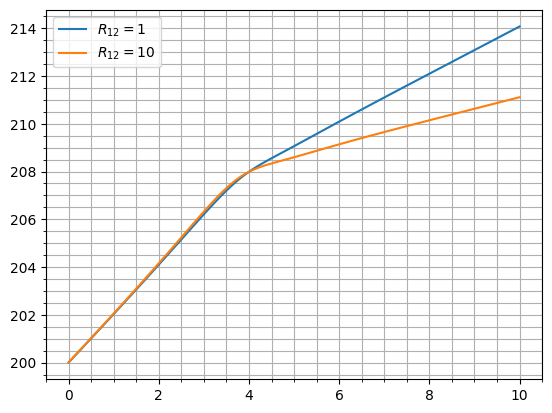

In [6]:
def plot_single_cross_example():
    intercept = 0 
    C_12 = 4
    slope_1 = 2
    slope_2 = 1
    
    x = np.linspace(0, 10, num=101, endpoint=True)
    # y_01 = single_cross_fcn(x, intercept, C_12, slope_1, slope_2, 0.1)
    y_1 = single_cross_fcn(x, intercept, C_12, slope_1, slope_2, 1)
    y_10 = single_cross_fcn(x, intercept, C_12, slope_1, 0.5, 1)
    
    fig, ax = plt.subplots()
    # plt.plot(x, y_01, label="$R_{12} = 0.1$")
    plt.plot(x, y_1 , label="$R_{12} = 1$")
    plt.plot(x, y_10 , label="$R_{12} = 10$")
    plt.grid(which='both')
    ax.minorticks_on()
    plt.legend()
    # plt.xlim(3, 6)
    plt.show()
plot_single_cross_example()

In [7]:
@dataclass
class var_estimation:
    value: float
    stderr: float

@dataclass
class dfa_params:
    intercept: var_estimation
    cross: var_estimation
    slope_l: var_estimation
    slope_h: var_estimation
    rigidity:var_estimation

C:\Users\siniz\AppData\Local\Temp\ipykernel_24384\1638365719.py:5: RuntimeWarning: overflow encountered in exp
  return np.log(1 + np.exp(R *(x - C))) / R * - (x-C) / np.sqrt(1 + (x-C)**2)


Opt S = 2.464473273962673; H_l(S) = 1.0076772377147893; H_h(S) = 0.5249643829868552; y_0 = -0.7257301671837049 
[3.61695834e+097 3.64435297e+098 9.13491891e+098 1.83496363e+099
 4.07618520e+099 4.35190108e+099 1.01208014e+100 8.98826610e+099
 1.27095216e+100 1.95234846e+100 3.12034965e+100 2.76496359e+100
 4.56669216e+100 6.29450531e+100 1.22756163e+101 1.74597898e+101
 2.03948395e+101]


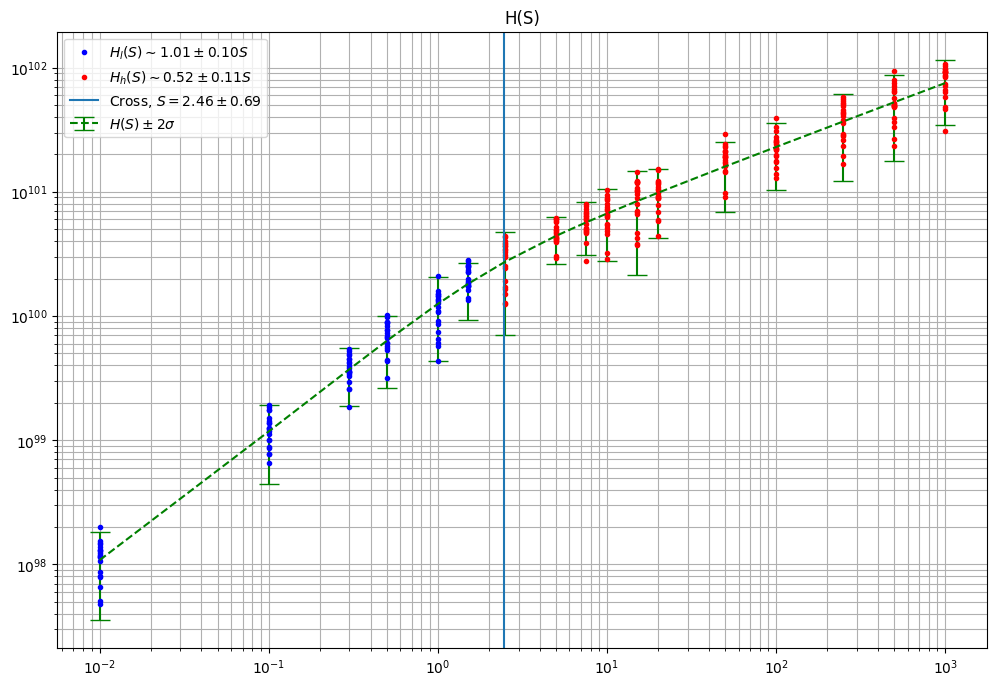

In [8]:
def analyse_dfa(hs, S):
    """
    hs: array_like The independent variable where the data is measured. Should usually be an M-length sequence or an (k,M)-shaped array for functions with k predictors, and each element should be float convertible if it is an array like object.
    S: array_like The dependent data, a length M array.
    """
    s = np.repeat(S[:,np.newaxis], hs.shape[0], 1).T
    assert s.shape == hs.shape, f"Shape of x and y must be equal, but {s.shape} and {hs.shape}"
    (intercept, cross, slope_l, slope_h, rigidity), pcov, infodict, mesg, ier = curve_fit(single_cross_fcn, 
                                                           np.log10(s.flatten()), 
                                                           np.log10(hs.flatten()), 
                                                           p0=(0,np.log10(S[len(S)//2]), 1, 1, 5),
                                                           bounds=([-np.inf, np.log10(S[0]), 0, 0, 1],
                                                                   [+np.inf, np.log10(S[-1]), 5, 5, +np.inf]),
                                                            full_output=True)
    
    return dfa_params(
        intercept=var_estimation(value=intercept, stderr=np.sqrt(pcov[0][0])),
        cross=var_estimation(value=10**cross, stderr=np.sqrt(pcov[1][1])),
        slope_l=var_estimation(value=slope_l, stderr=np.sqrt(pcov[2][2])),
        slope_h=var_estimation(value=slope_h, stderr=np.sqrt(pcov[3][3])),
        rigidity=var_estimation(value=rigidity, stderr=np.sqrt(pcov[4][4]))
    ), 10**single_cross_fcn(np.log10(S), intercept, cross, slope_l, slope_h, rigidity) - hs

def plot_analyse_dfa(hs, S, params:dfa_params, residuals:np.ndarray, title="H(S)"):
    if len(residuals.shape) == 1:
        residuals = np.expand_dims(residuals, -1)
        
    #
    n_sigm = 3
    cross = params.cross.value
    print(f"Opt S = {params.cross.value}; H_l(S) = {params.slope_l.value}; H_h(S) = {params.slope_h.value}; y_0 = {params.intercept.value} ")
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(title)
    
    print(np.std(residuals, axis=0))
    ax.errorbar(S, 
                 10**(single_cross_fcn(np.log10(S), 
                                params.intercept.value, 
                                np.log10(params.cross.value), 
                                params.slope_l.value, 
                                params.slope_h.value,
                                params.rigidity.value)), 
                fmt='g--',
                capsize=7,
                yerr=2*np.std(residuals, axis=0),
                label=f"$H(S) \pm 2 \sigma$")
    
    # print(np.std(residuals, axis=-1))
    S = np.repeat(S[:,np.newaxis], hs.shape[0], 1).T
    
    regr_l =  10**(params.intercept.value+params.slope_l.value*np.log10(S))
    # regr_l_upper_bound =  10**(params.intercept.value+params.slope_l.value*np.array(np.log10(S))+n_sigm*params.slope_l.stderr)
    # regr_l_lower_bound =  10**(params.intercept.value+params.slope_l.value*np.array(np.log10(S))-n_sigm*params.slope_l.stderr)
    
    ax.plot(S[S<=cross], hs[S<=cross], '.', color='blue', label=f"$H_l(S) \sim {params.slope_l.value:.2f} \pm {2*params.slope_l.stderr:.2f} S$")
    
    # ax.plot(S, regr_l, lw=1, label=f'$H_l(S) = {params.slope_l.value:.2f}, S<{cross:.2f}$', color='blue', ls='--')
    # plt.fill_between(S, regr_l_lower_bound, regr_l_upper_bound, facecolor='blue', alpha=0.25,
    #         label=f'${n_sigm} \sigma(H_l(S))$')


    regr_h =  regr_l[S<=cross][-1] + 10**(params.intercept.value+params.slope_h.value*np.log10(S))
    
    # regr_h_upper_bound =  10**(params.intercept.value+params.slope_h.value*np.array(np.log10(S))+n_sigm*params.slope_h.stderr)
    # regr_h_lower_bound =  10**(params.intercept.value+params.slope_h.value*np.array(np.log10(S))-n_sigm*params.slope_h.stderr)
    
    
    ax.plot(S[S>cross], hs[S>cross], '.', color='red', label=f"$H_h(S)  \sim {params.slope_h.value:.2f} \pm {2*params.slope_h.stderr:.2f} S$")
    # ax.plot(S, regr_h, lw=1, label=f'$H_h(S) = {params.slope_h.value:.2f}, S>={cross:.2f}$', color='red', ls='--')
    # plt.fill_between(S, regr_h_lower_bound, regr_h_upper_bound, facecolor='red', alpha=0.25,
    #         label=f'${n_sigm} \sigma(H_l(S))$')

    ax.axvline(params.cross.value, label=f"Cross, $S = {params.cross.value:.2f} \pm {params.cross.stderr:.2f}$")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(which='both')
    ax.legend()
    plt.plot()
    
    


tst_s = np.array([0.01, 0.1, 0.3, 0.5, 1, 1.5, 2.5, 5, 7.5, 10, 15, 20, 50, 100, 250, 500, 1000])
# tst_h = np.zeros_like(tst_s)
tst_cross = 5
# tst_h[:tst_cross] = 10**(2*np.array(np.log10(tst_s[:tst_cross])))
# tst_h[tst_cross:] = tst_h[tst_cross-1] + 10**(1*np.array(np.log10(tst_s[tst_cross:])))

tst_h = 10**single_cross_fcn(np.log10(tst_s), 0, np.log10(tst_cross), 1, 0.5, 1)

tst_hr = 1 + np.random.normal(0, 0.3, (20, len(tst_h)))
tst_hr *= tst_h



# plt.figure()
# plt.plot(tst_s, tst_hr)
# plt.xscale('log')
# plt.yscale('log')
# plt.grid(which='both')
# plt.show()

params, residuals  = analyse_dfa(tst_hr, tst_s)

plot_analyse_dfa(tst_hr, tst_s, params, residuals)